In [1]:
!nvidia-smi

Tue Feb 17 15:20:20 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   31C    P0             49W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import os
import gc
import sys
import torch
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
from torch import nn
from transformers import AutoTokenizer, AutoModel, BertTokenizerFast, BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, AutoConfig
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import torch


In [3]:
print('Working dir:', os.getcwd())

Working dir: /content


In [4]:
# All models
BERT = "bert-base-multilingual-cased"
ROBERTA = "FacebookAI/xlm-roberta-base" # Roberta multilangual
CAMEMBERT = "camembert-base" # RoBerta adapted for french
DISTIL_CAMEMBERT = "cmarkea/distilcamembert-base" # CAMEMBERT french smaller
LONGFORMER = "abazoge/DrLongformer"
BIGBIRD = "google/bigbird-roberta-base"

Data Preprocessing

In [5]:
"""
Module to transform data to be consumable by model
"""

class DatabaseToBertDataset():
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name) # ("bert-base-multilingual-cased")
        self.tokenizerChunkLen = self.tokenizer.model_max_length

        config = AutoConfig.from_pretrained(model_name)
        self.maxTokensLength = config.max_position_embeddings


        # "allenai/longformer-base-4096" has no max_length
        if model_name == CAMEMBERT or DISTIL_CAMEMBERT:
            self.maxTokensLength = 512
        if model_name == LONGFORMER:
            self.maxTokensLength = 4096

    def _tokenize(self, df: str) -> pd.DataFrame:
        """Tokenizer function"""
        tokenized = self.tokenizer(
            df["email"].to_list(),
            df["bill"].to_list(),
            padding='max_length',
            max_length=self.maxTokensLength,
            truncation=True,
            stride=128,                        # overlap between chunks
            return_overflowing_tokens=True,    # keep extra chunks
            return_offsets_mapping=True,       # optional: track positions in original text
            return_tensors="pt"                # PyTorch tensors
        )

        # input(tokenized.keys())

        # print(type(tokenized))
        # print(tokenized['input_ids'].shape)
        # print(tokenized['token_type_ids'].shape)
        # print(tokenized['attention_mask'].shape)
        # print(tokenized['offset_mapping'].shape)
        # print(tokenized['overflow_to_sample_mapping'].shape)
        # input('MMMM')

        return tokenized

    def tokenize_by_row(self, row: pd.Series):
        text = self._join_text_fields(row)
        tokenized = self.tokenizer(
            text,
            padding='max_length',
            max_length=self.maxTokensLength,
            truncation=True,
            stride=128,                        # overlap between chunks
            return_overflowing_tokens=True,    # keep extra chunks
            return_offsets_mapping=True,       # optional: track positions in original text
            return_tensors="pt"                # PyTorch tensors
        )

        return tokenized

    def _join_text_fields(self, row):
        parts = []
        for k in ["email", "bill"]:
            if row[k]:
                parts.append(row[k])
        return " [SEP] ".join(parts)

    def _encode_labels(self, df: pd.DataFrame) -> tuple[pd.DataFrame, np.ndarray]:
        """Encode labels"""

        df = df.copy()
        # Get unique labels from labels description
        with open('labels.json', 'r') as file:
            labels = json.load(file)['etiquettes']
        labelIds = [label['id'] for label in labels]

        # Format original labels
        df['labels'] = df['labels'].apply(
            lambda x: x.split('|') if isinstance(x, str) else []
        )

        # Encode
        mlb = MultiLabelBinarizer(classes=labelIds)
        encoded = mlb.fit_transform(df['labels'])
        df = pd.concat(
            [df, pd.DataFrame(encoded, columns=mlb.classes_)],
            axis=1
        )
        df = df.drop(columns='labels')

        return df, mlb.classes_


    def execute(self, df : pd.DataFrame) -> tuple[dict[torch.Tensor], np.ndarray]:
        """
        Transform from database to dataset consumable by model
        """
        df = df.copy()
        # Tokenize ('input_ids' 'attention_mask''token_type_ids' 'overflow_to_sample_mapping')
        tokenized = df.apply(lambda row: self.tokenize_by_row(row), axis=1)


        labels = None
        if 'labels' in df.columns:
            df, labelNames = self._encode_labels(df)
            labels = torch.tensor(df[labelNames].to_numpy())

        return tokenized.to_list(),  labels, labelNames

In [6]:
# def collate_variable_docs(batch, pad_token_id=0):
#     """
#     batch: list of tuples (input_ids, attn_mask, token_type_ids, label)
#     where each input_ids has shape [num_chunks, 512]
#     """
#
#     input_ids_list, attn_list, token_type_list, label_list = zip(*batch)
#
#     # Find max num_chunks in this batch
#     max_chunks = max(x.shape[0] for x in input_ids_list)
#     chunk_len = input_ids_list[0].shape[1]
#
#     def pad_to_max_chunks(x, pad_val = 0):
#         pad_chunks = max_chunks - x.shape[0]
#         if pad_chunks > 0:
#             pad = torch.full((pad_chunks, chunk_len), pad_val, dtype=torch.long)
#             x = torch.cat([x, pad], dim=0)
#         return x
#
#     input_ids = torch.stack([pad_to_max_chunks(x, pad_token_id) for x in input_ids_list])
#     attn_mask = torch.stack([pad_to_max_chunks(x) for x in attn_list])
#     token_types = torch.stack([pad_to_max_chunks(x) for x in token_type_list])
#     labels = torch.stack(label_list)
#
#     return input_ids, attn_mask, token_types, labels
#
# class BertTokenizedDataset(Dataset):
#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels
#
#     def __len__(self):
#         return len(self.data)
#
#     def __getitem__(self, idx):
#         # Just return what you already have
#         sample = self.data[idx]
#         x = []
#         return sample['input_ids'], sample['attention_mask'], sample['token_type_ids'], self.labels[idx]
#
# databaseToBertDataset = DatabaseToBertDataset(model_name="bert-base-multilingual-cased")
# df = pd.read_csv('data.csv')
# data, labels, labels_list = databaseToBertDataset.execute(df)
#
#
# dataset = BertTokenizedDataset(
#     data,
#     labels,
# )
#
#
# train_loader = DataLoader(dataset, batch_size=4, shuffle=True,
#                           collate_fn=(lambda batch: collate_variable_docs(batch, databaseToBertDataset.tokenizer.pad_token_id)))
#
#
# for batch_idx, batch in enumerate(train_loader):
#
#     input_ids = batch[0]
#     attention_mask = batch[1]
#     token_type_ids = batch[2]
#     labels = batch[3]
#
#     print('asdasdasd')
#     print(input_ids[0])
#     print(attention_mask.shape)
#     print(token_type_ids.shape)
#     print(labels.shape)
#


Models

In [7]:
class BertHierachicalClassifier(nn.Module):
    def __init__(self, model_name, num_labels, freeze_bert=False):
        super().__init__()
        self.modelName = model_name
        self.bert = AutoModel.from_pretrained(self.modelName)
        self.dropout = nn.Dropout(0.2)


        self.chunk_transformer = nn.TransformerEncoderLayer(
            d_model=self.bert.config.hidden_size,
            nhead=8,
            batch_first=True
        )

        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, x):
        input_ids = batch[0]
        attention_mask = batch[1]
        token_type_ids = batch[2]

        B, N, L = input_ids.shape

        # Merge batch and chunk dims: treat all chunks as separate sequences
        input_ids = input_ids.view(B * N, L)
        attention_mask = attention_mask.view(B * N, L)
        if token_type_ids is not None:
            token_type_ids = token_type_ids.view(B * N, L)

        # Pass through BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # outputs.pooler_output: [B*N, hidden]
        chunk_embeddings = outputs.pooler_output
        chunk_embeddings = chunk_embeddings.view(B, N, -1)  # group back by document


        # The BERT model returns:
        # - last_hidden_state: (batch_size, seq_len, hidden_dim)
        # - pooler_output: (batch_size, hidden_dim)
        last_hidden_state = outputs.last_hidden_state # (batch_size, seq_len, hidden_dim)
        pooled_output = outputs.pooler_output  # [CLS] embedding after tanh layer

        # Aggregate chunk embeddings (you can replace with attention or mean)
        doc_embeds = self.chunk_transformer(chunk_embeddings)
        doc_embeds = doc_embeds.mean(dim=1)  # mean over chunks

        # Classification
        out = self.classifier(self.dropout(doc_embeds))

        return out

class CamembertHierachicalClassifier(nn.Module):
    def __init__(self, model_name, num_labels, freeze_bert=False):
        super().__init__()
        self.modelName = model_name
        self.bert = AutoModel.from_pretrained(self.modelName)
        self.dropout = nn.Dropout(0.2)


        self.chunk_transformer = nn.TransformerEncoderLayer(
            d_model=self.bert.config.hidden_size,
            nhead=8,
            batch_first=True
        )

        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, x):
        input_ids = batch[0]
        attention_mask = batch[1]

        B, N, L = input_ids.shape

        # Merge batch and chunk dims: treat all chunks as separate sequences
        input_ids = input_ids.view(B * N, L)
        attention_mask = attention_mask.view(B * N, L)

        # Pass through BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        # outputs.pooler_output: [B*N, hidden]
        chunk_embeddings = outputs.pooler_output
        chunk_embeddings = chunk_embeddings.view(B, N, -1)  # group back by document


        # The BERT model returns:
        # - last_hidden_state: (batch_size, seq_len, hidden_dim)
        # - pooler_output: (batch_size, hidden_dim)
        last_hidden_state = outputs.last_hidden_state # (batch_size, seq_len, hidden_dim)
        pooled_output = outputs.last_hidden_state[:, 0, :] # outputs.pooler_output  # [CLS] embedding after tanh layer

        # Aggregate chunk embeddings (you can replace with attention or mean)
        doc_embeds = self.chunk_transformer(chunk_embeddings)
        doc_embeds = doc_embeds.mean(dim=1)  # mean over chunks

        # Classification
        out = self.classifier(self.dropout(doc_embeds))

        return out

class CamembertHierachicalClassifierV2(nn.Module):
    def __init__(self, model_name, num_labels, freeze_bert=False):
        super().__init__()
        self.modelName = model_name
        self.bert = AutoModel.from_pretrained(self.modelName)
        self.dropout = nn.Dropout(0.2)


        self.chunk_transformer = nn.TransformerEncoderLayer(
            d_model=self.bert.config.hidden_size,
            nhead=8,
            batch_first=True
        )

        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, x):
        input_ids = batch[0]
        attention_mask = batch[1]

        B, N, L = input_ids.shape

        # Merge batch and chunk dims: treat all chunks as separate sequences
        input_ids = input_ids.view(B * N, L)
        attention_mask = attention_mask.view(B * N, L)

        # Pass through BERT (TAKE ALL OUTPUT)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        token_emb = outputs.last_hidden_state              # [B*N, L, H]
        mask = attention_mask.unsqueeze(-1).float()        # [B*N, L, 1]

        # masked mean pooling
        sum_emb = (token_emb * mask).sum(dim=1)            # [B*N, H]
        len_emb = mask.sum(dim=1).clamp(min=1e-6)          # [B*N, 1]
        chunk_embeddings = sum_emb / len_emb               # [B*N, H]

        chunk_embeddings = chunk_embeddings.view(B, N, -1) # [B, N, H]


        # The BERT model returns:
        # - last_hidden_state: (batch_size, seq_len, hidden_dim)
        # - pooler_output: (batch_size, hidden_dim)
        last_hidden_state = outputs.last_hidden_state # (batch_size, seq_len, hidden_dim)
        pooled_output = outputs.last_hidden_state[:, 0, :] # outputs.pooler_output  # [CLS] embedding after tanh layer

        # Aggregate chunk embeddings (you can replace with attention or mean)
        doc_embeds = self.chunk_transformer(chunk_embeddings)
        doc_embeds = doc_embeds.mean(dim=1)  # mean over chunks

        # Classification
        out = self.classifier(self.dropout(doc_embeds))

        return out

class CamembertHierarchicalGRUClassifier(nn.Module):
    def __init__(self, model_name, num_labels, freeze_bert=False, gru_hidden=384, num_gru_layers=1):
        super().__init__()

        self.modelName = model_name
        self.bert = AutoModel.from_pretrained(self.modelName)

        hidden_size = self.bert.config.hidden_size

        # ---- GLOBAL ENCODER: BiGRU over chunks ----
        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=gru_hidden,
            num_layers=num_gru_layers,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(0.2)

        # Final classifier: takes BiGRU output (2*hidden because bidirectional)
        self.classifier = nn.Linear(gru_hidden * 2, num_labels)

        # Optionally freeze BERT
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False


    def forward(self, batch):
        input_ids = batch[0]          # (B, N, L)
        attention_mask = batch[1]     # (B, N, L)

        B, N, L = input_ids.shape

        # ---- Flatten chunks so BERT can process them in one batch ----
        input_ids = input_ids.view(B * N, L)
        attention_mask = attention_mask.view(B * N, L)

        # ---- Local transformer over tokens ----
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        # One embedding per chunk → [CLS] or pooler_output
        chunk_emb = outputs.last_hidden_state[:, 0, :]     # (B*N, hidden)
        # If CamemBERT returns None for pooler_output, use CLS token:
        # chunk_embeddings = outputs.last_hidden_state[:, 0, :]

        # Rebuild (B, N, hidden)
        chunk_emb = chunk_emb.view(B, N, -1)

        # GRU
        # h_n: (num_layers * num_directions, B, hidden)
        _, h_n = self.gru(chunk_emb)

        # Extract final BiGRU state
        # h_n[-2] = final state of backward
        # h_n[-1] = final state of forward
        h_forward = h_n[-1]
        h_backward = h_n[-2]
        doc_rep = torch.cat([h_backward, h_forward], dim=-1)

        logits = self.classifier(self.dropout(doc_rep))

        return logits


class LongformerClassifier(nn.Module):
    def __init__(self, model_name, num_labels, freeze_bert=False):
        super().__init__()
        # "allenai/longformer-base-4096" NOT IN FRENCH... :(
        self.modelName = LONGFORMER
        self.bert = AutoModel.from_pretrained(self.modelName)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, x):
        input_ids, attention_mask = x

        # BERT outputs all hidden states
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # The BERT model returns:
        # - last_hidden_state: (batch_size, seq_len, hidden_dim)
        # - pooler_output: (batch_size, hidden_dim)
        last_hidden_state = outputs.last_hidden_state # (batch_size, seq_len, hidden_dim)
        pooled_output = outputs.pooler_output  # [CLS] embedding after tanh layer

        # Apply dropout + classification on the pooled [CLS] representation
        out = self.classifier(self.dropout(pooled_output))

        return out

class BigbirdClassifier(nn.Module):
    def __init__(self, model_name, num_labels, freeze_bert=False):
        super().__init__()
        self.modelName = BIGBIRD
        self.bert = AutoModel.from_pretrained(self.modelName)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, x):
        input_ids, attention_mask = x

        # BERT outputs all hidden states
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # The BERT model returns:
        # - last_hidden_state: (batch_size, seq_len, hidden_dim)
        # - pooler_output: (batch_size, hidden_dim)
        last_hidden_state = outputs.last_hidden_state # (batch_size, seq_len, hidden_dim)
        pooled_output = outputs.pooler_output  # [CLS] embedding after tanh layer

        # Apply dropout + classification on the pooled [CLS] representation
        out = self.classifier(self.dropout(pooled_output))

        return out


Evaluate

In [8]:
def init_eval_metrics() -> dict[list[float|dict]]:
    """
    Init of the evaluation metrics
    """
    return {
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_micro': [],
        'f1_macro_avg': [],
        'f1_weighted_avg': [],
        'f1_macro': []
    }

def compute_eval_metrics(loss, all_labels, all_preds, labels_list) -> dict[list[float]]:
  """
  Computes evaluation metrics
  """
  f1Report = classification_report(all_labels, all_preds, target_names=labels_list, output_dict=True, zero_division=0)


  evalMetric = init_eval_metrics()
  evalMetric['loss'].append(loss)
  evalMetric['accuracy'].append(accuracy_score(all_labels, all_preds))
  evalMetric['precision'].append(f1Report["micro avg"]["precision"])
  evalMetric['recall'].append(f1Report["micro avg"]["recall"])
  evalMetric['f1_micro'].append(f1Report["micro avg"]["f1-score"])
  evalMetric['f1_macro_avg'].append(f1Report["macro avg"]["f1-score"])
  evalMetric['f1_weighted_avg'].append(f1Report["weighted avg"]["f1-score"])
  evalMetric['f1_macro'].append(f1Report)

  return evalMetric


def save_eval_metrics(eval_metrics, evalMetric):
    """
    Saves metrics
    """
    for metricName, val in eval_metrics.items():
        eval_metrics[metricName] = eval_metrics[metricName] + evalMetric[metricName]

def print_eval_metrics(eval_metrics):
    """
    Prints mean metrics
    """
    loss = sum(eval_metrics['loss'])/len(eval_metrics['loss'])
    accuracy = sum(eval_metrics['accuracy'])/len(eval_metrics['accuracy'])
    precision = sum(eval_metrics['precision'])/len(eval_metrics['precision'])
    recall = sum(eval_metrics['recall'])/len(eval_metrics['recall'])
    f1Micro = sum(eval_metrics['f1_micro'])/len(eval_metrics['f1_micro'])
    f1MacroAvg = sum(eval_metrics['f1_macro_avg'])/len(eval_metrics['f1_macro_avg'])


    print(f"  Accuracy: {accuracy:.4f} F1-Micro: {f1Micro:.4f} F1-Macro-Avg {f1MacroAvg:.4f} Precision: {precision:.4f} Recall: {recall:.4f}")


def eval_metrics_to_df(eval_metrics) -> tuple[pd.DataFrame]:
    """
    Full display all metrics
    """

    # Golbal metrics
    globalMetrics = {}
    for metricName, val in eval_metrics.items():
        if 'f1_macro' == metricName:
          continue
        valMean = sum(eval_metrics[metricName])/len(eval_metrics[metricName])
        globalMetrics[metricName] = valMean
    globalMetricsDf = pd.DataFrame([globalMetrics])


    # Label metrics
    f1MacrosDfs = [pd.DataFrame(r).transpose() for r in eval_metrics['f1_macro']]
    f1MacrosDf = pd.concat(f1MacrosDfs).groupby(level=0).mean(numeric_only=True)
    f1MacrosDf = f1MacrosDf.drop(index=["micro avg", "macro avg", "weighted avg", "samples avg"])

    return globalMetricsDf, f1MacrosDf


def plot_losses(trainLosses, evalLosses):
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(trainLosses, label='Training Loss', marker='o')
    plt.plot(evalLosses, label='Validation Loss', marker='o')

    plt.yscale('log')

    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Train

In [9]:
def collate_variable(batch, pad_token_id=0):
    """
    batch: list of tuples (input_ids, attn_mask, token_type_ids, label)
    where each input_ids has shape [num_chunks, 512]
    """

    input_ids_list, attn_list, token_type_list, label_list = zip(*batch)

    # Find max num_chunks in this batch
    max_chunks = max(x.shape[0] for x in input_ids_list)
    chunk_len = input_ids_list[0].shape[1]

    def pad_to_max_chunks(x, pad_val = 0):
        pad_chunks = max_chunks - x.shape[0]
        if pad_chunks > 0:
            pad = torch.full((pad_chunks, chunk_len), pad_val, dtype=torch.long)
            x = torch.cat([x, pad], dim=0)
        return x

    input_ids = torch.stack([pad_to_max_chunks(x, pad_token_id) for x in input_ids_list])
    attn_mask = torch.stack([pad_to_max_chunks(x) for x in attn_list])
    token_types = torch.stack([pad_to_max_chunks(x) for x in token_type_list])
    labels = torch.stack(label_list).float()

    return input_ids, attn_mask, token_types, labels

def collate_variable_no_token_types(batch, pad_token_id=0):
    """
    batch: list of tuples (input_ids, attn_mask, token_type_ids, label)
    where each input_ids has shape [num_chunks, 512]
    """

    input_ids_list, attn_list, label_list = zip(*batch)

    # Find max num_chunks in this batch
    max_chunks = max(x.shape[0] for x in input_ids_list)
    chunk_len = input_ids_list[0].shape[1]

    def pad_to_max_chunks(x, pad_val = 0):
        pad_chunks = max_chunks - x.shape[0]
        if pad_chunks > 0:
            pad = torch.full((pad_chunks, chunk_len), pad_val, dtype=torch.long)
            x = torch.cat([x, pad], dim=0)
        return x

    input_ids = torch.stack([pad_to_max_chunks(x, pad_token_id) for x in input_ids_list])
    attn_mask = torch.stack([pad_to_max_chunks(x) for x in attn_list])
    labels = torch.stack(label_list).float()

    return input_ids, attn_mask, labels

class TokenizedDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.collateFunc = collate_variable

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Just return what you already have
        sample = self.data[idx]
        x = []
        return sample['input_ids'], sample['attention_mask'], sample['token_type_ids'], self.labels[idx]


class TokenizedDatasetNoType(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.collateFunc = collate_variable_no_token_types

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Just return what you already have
        sample = self.data[idx]
        x = []
        return sample['input_ids'], sample['attention_mask'], self.labels[idx]

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # For multi-GPU
    torch.cuda.manual_seed_all(seed)

    # Make cuDNN deterministic (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [10]:
set_seed(42)

HIERACHICAL_TRANSFORMER = 'HIERACHICAL_TRANSFORMER'
HIERACHICAL_TRANSFORMERV2 = 'HIERACHICAL_TRANSFORMERV2'
HIERACHICAL_GRU = 'HIERACHICAL_GRU'

gc.collect()
torch.cuda.empty_cache()

# Read data
df = pd.read_csv('data.csv')
df['bills'].fillna('', inplace=True)
df = df.rename(columns={"emails": "email", "bills": "bill"})
df['labels'] = df['labels'].apply(lambda x: x.replace(' ', '').replace(',', '|') if isinstance(x, str) else [])


# Train/val/test split
trainRatio = 0.7
valRatio = 0.25
testRatio = 0.05
trainDf, valTestDf = train_test_split(df, train_size=trainRatio, random_state=42)
relativeRatio = valRatio/(valRatio + testRatio)
valDf, testDf = train_test_split(valTestDf, train_size=relativeRatio, random_state=42)

trainDf = trainDf.reset_index()
valDf = valDf.reset_index()
testDf = testDf.reset_index()

# === CONFIG ===
MODEL_NAME_BERT =  CAMEMBERT # ROBERTA # DISTIL_CAMEMBERT # CAMEMBERT # BERT
MODEL_NAME = HIERACHICAL_TRANSFORMERV2 # HIERACHICAL_TRANSFORMER # HIERACHICAL_TRANSFORMERV2 # HIERACHICAL_GRU

epochs = 250
batch_size = 4
threshold = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'CONFIG: batch_size={batch_size}, epochs={epochs}, device={device}')
print('')


# === Eval Variables ===
evalMetrics = init_eval_metrics()

# === Tokenize ===
databaseToBertDataset = DatabaseToBertDataset(model_name=MODEL_NAME_BERT)
train_data, train_labels, labels_list = databaseToBertDataset.execute(trainDf)
val_data, val_labels, _ = databaseToBertDataset.execute(valDf)

if MODEL_NAME_BERT == BERT:
    # === Datasets ===
    train_dataset = TokenizedDataset(
        train_data,
        train_labels
    )
    val_dataset = TokenizedDataset(
        val_data,
        val_labels
    )

    # === Model ===
    model = BertHierachicalClassifier(MODEL_NAME_BERT, num_labels=len(labels_list))

elif MODEL_NAME_BERT == CAMEMBERT or MODEL_NAME_BERT == DISTIL_CAMEMBERT or MODEL_NAME_BERT == ROBERTA:

    # === Datasets ===
    train_dataset = TokenizedDatasetNoType(
        train_data,
        train_labels
    )
    val_dataset = TokenizedDatasetNoType(
        val_data,
        val_labels
    )

    # === Model ===
    if MODEL_NAME == HIERACHICAL_TRANSFORMER:
        model = CamembertHierachicalClassifier(MODEL_NAME_BERT, num_labels=len(labels_list))
    elif MODEL_NAME == HIERACHICAL_TRANSFORMERV2:
        model = CamembertHierachicalClassifierV2(MODEL_NAME_BERT, num_labels=len(labels_list))
    elif MODEL_NAME == HIERACHICAL_GRU:
        model = CamembertHierarchicalGRUClassifier(MODEL_NAME_BERT, num_labels=len(labels_list))

elif MODEL_NAME_BERT == LONGFORMER:

    # === Datasets ===
    train_dataset = TensorDataset(
        train_data["input_ids"],
        train_data["attention_mask"],
        train_data["labels"].float()
    )
    val_dataset = TensorDataset(
        val_data["input_ids"],
        val_data["attention_mask"],
        val_data["labels"].float()
    )

    # === Model ===
    model = LongformerClassifier(MODEL_NAME_BERT, num_labels=len(labels_list))

elif MODEL_NAME_BERT == BIGBIRD:

    # === Datasets ===
    train_dataset = TensorDataset(
        train_data["input_ids"],
        train_data["attention_mask"],
        train_data["labels"].float()
    )
    val_dataset = TensorDataset(
        val_data["input_ids"],
        val_data["attention_mask"],
        val_data["labels"].float()
    )

    # === Model ===
    model = BigbirdClassifier(MODEL_NAME_BERT, num_labels=len(labels_list))


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
          collate_fn=(lambda batch: train_dataset.collateFunc(batch, databaseToBertDataset.tokenizer.pad_token_id)))

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False,
          collate_fn=(lambda batch: val_dataset.collateFunc(batch, databaseToBertDataset.tokenizer.pad_token_id)))

model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()
trainLosses = []
evalLosses = []

# === TRAINING LOOP ===
for epoch in range(epochs):
    model.train()

    sumLoss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        batch = [t.to(device, non_blocking=True) for t in batch]

        xTensor = batch[:-1]
        labels = batch[-1]

        optimizer.zero_grad()

        # Forward
        outputs = model(xTensor)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        sumLoss += loss.item()
        sys.stdout.write(f"\rEpoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")
        sys.stdout.flush()

    meanLoss = sumLoss / len(train_loader)
    trainLosses.append(meanLoss)
    sys.stdout.write(f"\rEpoch {epoch+1}/{epochs}, Batch {len(train_loader)}/{len(train_loader)} - Loss: {meanLoss:.4f}")
    sys.stdout.flush()

    # === EVALUATION LOOP ===
    model.eval()
    sumLossVal = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in val_loader:
            batch = [t.to(device, non_blocking=True) for t in batch]
            xTensor = batch[:-1]
            labels = batch[-1]

            outputs = model(xTensor)

            loss = criterion(outputs, labels)


            # --- Predictions ---
            preds = torch.sigmoid(outputs) > threshold  # (batch_size, num_labels)

            # Move to CPU for sklearn
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

            sumLossVal += loss.item()

    meanLossVal = sumLoss / len(val_loader)
    evalLosses.append(meanLossVal)

    # === Combine batches ===
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    # === Metrics ===
    avg_eval_loss = sum(evalLosses) / len(evalLosses)
    evalMetric = compute_eval_metrics(avg_eval_loss, all_labels, all_preds, labels_list)
    print_eval_metrics(evalMetric)

save_eval_metrics(evalMetrics, evalMetric)
# print_eval_metrics(evalMetrics)



/tmp/ipython-input-1310198469.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bills'].fillna('', inplace=True)
/tmp/ipython-input-1310198469.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['bills'].fillna('', inplace=True)


CONFIG: batch_size=4, epochs=250, device=cuda



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

CamembertModel LOAD REPORT from: camembert-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Epoch 1/250, Batch 27/27 - Loss: 0.5606  Accuracy: 0.0000 F1-Micro: 0.0000 F1-Macro-Avg 0.0000 Precision: 0.0000 Recall: 0.0000
Epoch 2/250, Batch 27/27 - Loss: 0.5094  Accuracy: 0.0000 F1-Micro: 0.0000 F1-Macro-Avg 0.0000 Precision: 0.0000 Recall: 0.0000
Epoch 3/250, Batch 27/27 - Loss: 0.5125  Accuracy: 0.0000 F1-Micro: 0.0000 F1-Macro-Avg 0.0000 Precision: 0.0000 Recall: 0.0000
Epoch 4/250, Batch 27/27 - Loss: 0.4650  Accuracy: 0.0811 F1-Micro: 0.3902 F1-Macro-Avg 0.3240 Precision: 0.7273 Recall: 0.2667
Epoch 5/250, Batch 27/27 - Loss: 0.3947  Accuracy: 0.2703 F1-Micro: 0.5630 F1-Macro-Avg 0.5084 Precision: 0.8444 Recall: 0.4222
Epoch 6/250, Batch 27/27 - Loss: 0.3136  Accuracy: 0.2162 F1-Micro: 0.5839 F1-Macro-Avg 0.5156 Precision: 0.8511 Recall: 0.4444
Epoch 7/250, Batch 27/27 - Loss: 0.2387  Accuracy: 0.2973 F1-Micro: 0.6933 F1-Macro-Avg 0.6831 Precision: 0.8667 Recall: 0.5778
Epoch 8/250, Batch 27/27 - Loss: 0.1945  Accuracy: 0.3243 F1-Micro: 0.7682 F1-Macro-Avg 0.7652 Precision

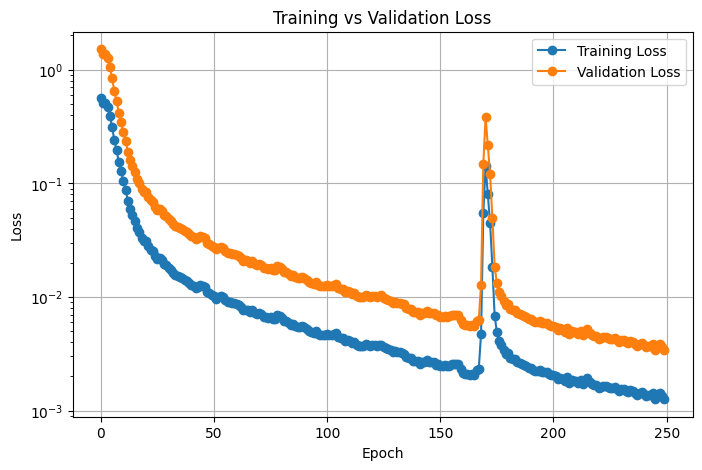

In [11]:
plot_losses(trainLosses, evalLosses)

In [12]:
globalMetricsDf, labelMetricsDf = eval_metrics_to_df(evalMetrics)

In [13]:
globalMetricsDf

,loss,accuracy,precision,recall,f1_micro,f1_macro_avg,f1_weighted_avg
0,0.060583,0.72973,0.963415,0.877778,0.918605,0.921588,0.912342


In [14]:
labelMetricsDf

,precision,recall,f1-score,support
aide_hygiene_personnelle,0.833333,1.000000,0.909091,5.0
commission_faire_marche,0.923077,1.000000,0.960000,12.0
cuisiner,1.000000,0.714286,0.833333,7.0
logistique_medicale,1.000000,0.857143,0.923077,7.0
menage_epoussetage,1.000000,1.000000,1.000000,6.0
menage_lessive,1.000000,0.800000,0.888889,10.0
menage_plancher,1.000000,1.000000,1.000000,7.0
mobilite_confort,1.000000,1.000000,1.000000,9.0
mobilite_transport_accompagnement_rv,0.875000,0.583333,0.700000,12.0
nourrir_personne,1.000000,1.000000,1.000000,8.0
